In [1]:
import numpy as np
import pandas as pd
import random
import cvxopt
from cvxopt import matrix, solvers
from cvxopt.modeling import variable
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from libsvm.svmutil import *
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
random.seed(42)

In [2]:
SUBSET = [False,2000] # if True, 2nd val is # of points 
N_FOLDS = 5 # k-Fold cross validation
NUM_FEATURES = 25 # <=25 for the given data
SPLIT = 0.9 # Test-train split (for individual)
MODE = 'LIBSVM' # 'LIBSVM', 'CVXOPT', 'SSMO'
BINARY_CLASSIFICATION = False # Binary classification/Multiclass
C1,C2 = 1,8 # Classes (0-9)
KERNEL = 'LINEAR' # 'LINEAR', 'POLY', 'RBF'
GAMMA = 0.001 # Gamma for RBF Kernel
C = 3.0 # C for L1 regularization
POWER = 2 # Power in Polynomial kernel
COEFF = 4 # Coefficient in Polynomial kernel
MAX_PASSES = 5 # Number of passes in SSMO
TOLERANCE = 1e-3 # Tolerance for SSMO

In [3]:
def getData():
    df = pd.read_csv('train_set.csv',header=None)
    if BINARY_CLASSIFICATION:
        df = df[(df[25] == C1) | (df[25] == C2)]
    dataset = []
    for i,row in df.iterrows():
        xi = []
        for j in range(0,NUM_FEATURES):
            xi.append(row[j])
        if BINARY_CLASSIFICATION:
            if(row[25]==C1):
                xi.append(-1.0)
            else:
                xi.append(1.0)
        else:
            xi.append(row[25])
        dataset.append(xi)
    
    if SUBSET[0]==True:
        dataset = dataset[:SUBSET[1]]
    return dataset

In [4]:
def cross_validation_split(dataset):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / N_FOLDS)
    for i in range(N_FOLDS):
        fold = list()
        while len(fold) < fold_size:
            index = random.randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [5]:
dataset = getData()

In [6]:
dataset_split = cross_validation_split(dataset)

In [7]:
class SVM:
    def __init__(self,mode='CVXOPT',kernel='LINEAR',C = 3.0,gamma = 0.001, power = 2, coeff = 4, max_passes = 5, tol=1e-3):
        self.mode = mode
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.power = power
        self.coeff = coeff
        self.max_passes = max_passes
        self.tol = tol
    
    def fit(self,X,y):
        X = np.array(X)
        y = np.array(y)
        num_samples,num_features = X.shape
        K = np.zeros((num_samples,num_samples))
        
        for i in (range(num_samples)):
            for j in range(num_samples):
                if self.kernel == 'LINEAR':
                    K[i][j] = np.dot(X[i],np.transpose(X[j]))
                elif self.kernel == 'POLY':
                    K[i][j] = (np.dot(X[i],np.transpose(X[j])) + self.coeff) ** self.power
                elif self.kernel == 'RBF':
                    K[i][j] = np.exp(-1 * self.gamma*np.sum(np.square(X[i]-X[j])))
        
        self.K = K
        
        if self.mode == 'CVXOPT':
            H = np.zeros((num_samples,num_samples))
            for i in (range(num_samples)):
                for j in range(num_samples):
                    H[i][j] = y[i]*y[j] * K[i][j]
            P = matrix(H)
            q = matrix(np.ones(num_samples) * -1)
            G = matrix(np.vstack(((np.identity(num_samples) * -1),np.identity(num_samples))))
            h = matrix(np.hstack((np.zeros(num_samples),np.ones(num_samples)*self.C)))
            A = matrix(y,(1,num_samples))
            b = matrix(0.0)

            solvers.options['show_progress'] = False
            soln = solvers.qp(P,q,G,h,A,b)
            alpha = np.array(soln['x']) 

            self.sup_idx = np.where(alpha>1e-5)[0]
            self.ind =  np.arange(len(alpha))[self.sup_idx]

            self.sup_x = X[self.sup_idx,:]
            self.sup_y = y[self.sup_idx]
            self.alpha = alpha[self.sup_idx]
            self.b = self.sup_y[0]

            for i in range(len(self.alpha)):
                if self.kernel == 'LINEAR':
                    temp = np.dot(self.sup_x[i],np.transpose(self.sup_x[0]))
                elif self.kernel == 'POLY':
                    temp = (np.dot(self.sup_x[i],np.transpose(self.sup_x[0]))+self.coeff)**self.power
                elif self.kernel == 'RBF':
                    temp = np.exp(-1 * self.gamma*np.sum(np.square(self.sup_x[i]-self.sup_x[0])))
                self.b -= self.alpha[i] * self.sup_y[i] * temp
        
        elif self.mode == 'SSMO':
            alpha = np.zeros((num_samples))
            alpha_old = np.zeros((num_samples))
            E = np.zeros((num_samples))
            b = 0
            passes = 0
            while(passes<self.max_passes):
                num_changed_alpha = 0
                for i in range(num_samples):
                    E[i] = np.sum(alpha * y * self.K[:,i]) + b - y[i]

                    if (y[i] * E[i] < -self.tol and alpha[i]<self.C) or (y[i] * E[i] > self.tol and alpha[i]>0):
                        j = random.randint(0,num_samples-1)
                        while j == i:
                            j = random.randint(0,num_samples-1)

                        E[j] = np.sum(alpha * y * self.K[:,j]) + b - y[j]
                        alpha_old[i] = alpha[i]
                        alpha_old[j] = alpha[j]

                        if y[i] != y[j]:
                            L = max(0,alpha[j] - alpha[i])
                            H = min(self.C,self.C+alpha[j] - alpha[i])
                        else:
                            L = max(0,alpha[i]+alpha[j] - self.C)
                            H = min(self.C,alpha[i] + alpha[j])

                        if L==H:
                            continue

                        eta = 2* self.K[i][j] - self.K[i][i] - self.K[j][j]

                        if eta>=0:
                            continue

                        alpha[j] = alpha[j] - y[j] * (E[i] - E[j])/eta

                        if alpha[j]>H:
                            alpha[j] = H
                        elif alpha[j]<L:
                            alpha[j] = L

                        if abs(alpha[j] - alpha_old[j]) < 1e-5:
                            continue

                        alpha[i] = alpha[i] + y[i]* y[j] * (alpha_old[j] - alpha[j])

                        b1 = b - E[i] - y[i] * (alpha[i] - alpha_old[i]) * self.K[i][i] \
                            - y[j] * (alpha[j] - alpha_old[j]) * self.K[i][j]
                        b2 = b - E[j] - y[i] * (alpha[i] - alpha_old[i]) * self.K[i][j] \
                            - y[j] * (alpha[j] - alpha_old[j]) * self.K[j][j] 

                        if 0<alpha[i] and alpha[i] <self.C:
                            b = b1
                        elif 0<alpha[j] and alpha[j] < self.C:
                            b = b2
                        else:
                            b = (b1+b2)/2

                        num_changed_alpha +=1

                if num_changed_alpha == 0:
                    passes+=1
                else:
                    passes=0

            self.b = b
            self.sup_idx = np.where(alpha>0)[0]
            self.sup_x = X[self.sup_idx,:]
            self.sup_y = y[self.sup_idx]
            self.alpha = alpha[self.sup_idx]
            self.w = np.dot(alpha*y,X).T
        
    def predict(self,X):
        preds = []
        for x in X:
            pred = 0
            for i in range(len(self.alpha)):
                if self.kernel == 'LINEAR':
                    temp = np.dot(self.sup_x[i],np.transpose(x))
                elif self.kernel == 'POLY':
                    temp = (np.dot(self.sup_x[i],np.transpose(x)) + self.coeff) ** self.power
                elif self.kernel == 'RBF':
                    temp = np.exp(-1 * self.gamma *np.sum(np.square(self.sup_x[i]-x)))
                pred += self.alpha[i] * self.sup_y[i] * temp
            pred += self.b
            if pred>=0:
                preds.append(1.0)
            else:
                preds.append(-1.0)
        return np.array(preds)

In [8]:
def getAccuracy(preds,testY):
    correct = 0
    for i in range(len(testY)):
        if preds[i] == testY[i]:
            correct +=1
    return correct/len(testY) * 100

In [9]:
def evaluateCrossEval(dataset_split):
    train_acc_list = []
    test_acc_list = []
    for fold in (dataset_split):
        trainDS = list(dataset_split)
        trainDS.remove(fold)
        trainDS = sum(trainDS,[])
        testDS = list()
        
        for row in fold:
            rowCopy = list(row)
            testDS.append(rowCopy)
        
        trainDS,testDS = testDS,trainDS
        
        trainX = [train[:-1] for train in trainDS]
        trainY = [train[-1] for train in trainDS]
        
        testX = [test[:-1] for test in testDS]
        testY = [test[-1] for test in testDS]
        
        if BINARY_CLASSIFICATION == False or MODE == 'LIBSVM':
            prob = svm_problem(trainY,trainX)
            param = svm_parameter()
            kernel_string_map = {
                'LINEAR': LINEAR,
                'POLY': POLY,
                'RBF': RBF
            }
            param.kernel_type = kernel_string_map[KERNEL]
            param.C = C
            param.gamma = GAMMA
            param.degree = POWER
            param.coef0 = COEFF
            m = svm_train(prob,param,'-q')
            t_label, t_acc, t_val = svm_predict(trainY, trainX, m,'-q')
            p_label, p_acc, p_val = svm_predict(testY, testX, m,'-q')
            train_acc_list.append(t_acc[0])
            test_acc_list.append(p_acc[0])
        else:
            cf = SVM(mode=MODE,kernel=KERNEL,gamma=GAMMA,C=C,power=POWER,coeff=COEFF,max_passes=MAX_PASSES,tol=TOLERANCE)
            cf.fit(trainX,trainY)
            
            train_preds = cf.predict(trainX)
            test_preds = cf.predict(testX)
            
            train_acc = getAccuracy(train_preds,trainY)
            test_acc = getAccuracy(test_preds,testY)
            test_acc_list.append(test_acc)
        
    return np.mean(train_acc_list),np.mean(test_acc_list)

In [10]:
evaluateCrossEval(dataset_split)

(97.35, 87.63125)

In [11]:
def evaluateSplit(dataset):
    n = len(dataset)
    trainDS = dataset[:int(SPLIT*n)]
    testDS = dataset[int(SPLIT*n):]
    
    trainX = [train[:-1] for train in trainDS]
    trainY = [train[-1] for train in trainDS]

    testX = [test[:-1] for test in testDS]
    testY = [test[-1] for test in testDS]
    
    if BINARY_CLASSIFICATION == False or MODE == 'LIBSVM':
        prob = svm_problem(trainY,trainX)
        param = svm_parameter()
        kernel_string_map = {
            'LINEAR': LINEAR,
            'POLY': POLY,
            'RBF': RBF
        }
        param.kernel_type = kernel_string_map[KERNEL]
        param.C = C
        param.gamma = GAMMA
        param.degree = POWER
        param.coef0 = COEFF
        m = svm_train(prob,param,'-q')
        t_label, t_acc, t_val = svm_predict(trainY, trainX, m,'-q')
        p_label, p_acc, p_val = svm_predict(testY, testX, m,'-q')
        return _,t_acc[0],p_acc[0]
    else:
        cf = SVM(mode=MODE,kernel=KERNEL,gamma=GAMMA,C=C,power=POWER,coeff=COEFF,max_passes=MAX_PASSES,tol=TOLERANCE)
        cf.fit(trainX,trainY)

        train_preds = cf.predict(trainX)
        test_preds = cf.predict(testX)

        train_acc = getAccuracy(train_preds,trainY)
        test_acc = getAccuracy(test_preds,testY)
        return cf.sup_idx,train_acc,test_acc
    

In [12]:
KERNEL = "LINEAR"
MODE = "LIBSVM"

In [13]:
train_acc_list = []
test_acc_list = []
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 11.8 10.8875
0.0001 12.0875 11.084375
0.001 83.575 81.49375
0.01 91.025 88.9125
0.1 93.9375 89.50625
1.0 96.6375 88.015625
10.0 98.1125 87.04375
100.0 98.5625 86.85


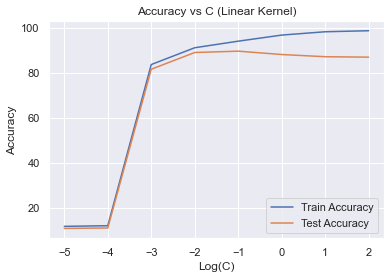

In [14]:
X = [-5,-4,-3,-2,-1,0,1,2]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (Linear Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (Linear Kernel).png',dpi=1200)
plt.show()


In [15]:
KERNEL = "RBF"

In [16]:
train_acc_list = []
test_acc_list = []
#GAMMA = 0.03
GAMMA = 1/(NUM_FEATURES)
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 11.8 10.8875
0.0001 11.8 10.8875
0.001 11.8 10.8875
0.01 15.0625 13.5625
0.1 92.075 88.8875
1.0 98.9875 94.546875
10.0 100.0 94.75
100.0 100.0 94.75625


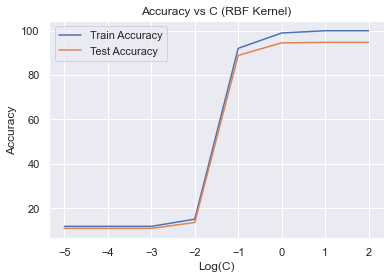

In [17]:
X = [-5,-4,-3,-2,-1,0,1,2]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (RBF Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (RBF Kernel).png',dpi=1200)
plt.show()

In [18]:
train_acc_list = []
test_acc_list = []
C = 1
for GAMMA in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(GAMMA,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 11.8 10.8875
0.0001 34.6125 33.16875
0.001 87.375 85.78125
0.01 94.975 91.93125
0.1 99.9375 93.946875
1.0 100.0 19.334375
10.0 100.0 10.9625


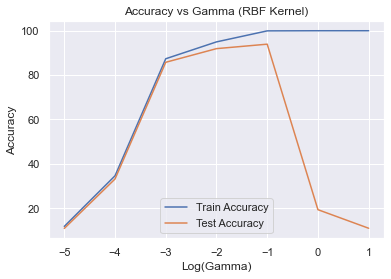

In [19]:
X = [-5,-4,-3,-2,-1,0,1]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(Gamma)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Gamma (RBF Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs Gamma (RBF Kernel).png',dpi=1200)
plt.show()

In [19]:
KERNEL = "RBF"
C = 4
GAMMA = 0.02
train_acc,test_acc = evaluateCrossEval(dataset_split)
print(GAMMA,train_acc,test_acc)

0.02 99.6125 94.321875


In [28]:
KERNEL = "RBF"
C = 1
GAMMA = 1/NUM_FEATURES

In [29]:
t1 = datetime.now()
train_acc,test_acc = evaluateCrossEval(dataset_split)
t2 = datetime.now()
print(t2-t1)
print(GAMMA,train_acc,test_acc)

0:00:04.060021
0.04 98.9875 94.546875


In [30]:
KERNEL = "RBF"
C = 1
GAMMA = 0.02

In [31]:
train_acc,test_acc = evaluateCrossEval(dataset_split)
print(GAMMA,train_acc,test_acc)

0.02 97.709375 95.8


In [32]:
KERNEL = "RBF"
C = 1
GAMMA = 0.05

In [33]:
train_acc,test_acc = evaluateCrossEval(dataset_split)
print(GAMMA,train_acc,test_acc)

0.05 99.33125 96.7875


In [94]:
KERNEL = "RBF"
C = 2.5
GAMMA = 0.05

In [95]:
train_acc,test_acc = evaluateCrossEval(dataset_split)
print(GAMMA,train_acc,test_acc)

0.05 99.95 94.878125


In [15]:
KERNEL = "RBF"

In [16]:
def gridSearch():
    global C
    global GAMMA
    df = pd.DataFrame()
    bestC, bestG = 0,0
    bestAcc = 0
    for C in tqdm(np.arange(0.1,4.05,0.05)):
        for GAMMA in tqdm(np.arange(0.01,0.12,0.0025)):
            try:
                train_acc,test_acc = evaluateCrossEval(dataset_split)
                if test_acc>bestAcc:
                    bestC = C
                    bestG = GAMMA
                    bestAcc = test_acc
                it = {'C':C,'Gamma':GAMMA,'trainAcc':train_acc, 'testAcc':test_acc}
                df = df.append(it,ignore_index=True)
            except:
                continue
        df.to_csv('grid_pt2.csv',index=False)
    return bestC,bestG

In [17]:
bestC,bestGAMMA = gridSearch()

In [18]:
bestC,bestGAMMA

(2.500000000000001, 0.05000000000000001)

In [145]:
res = pd.read_csv('grid_pt2.csv')

In [146]:
res = res[res['testAcc'] > 93]

In [147]:
res.head()

C   Gamma    testAcc  trainAcc
231  0.35  0.0375  93.018750   96.4625
232  0.35  0.0400  93.093750   96.6125
233  0.35  0.0425  93.112500   96.7125
234  0.35  0.0450  93.134375   96.8250
235  0.35  0.0475  93.153125   96.9625

In [148]:
res['Gamma']=np.array(round(res['Gamma'],5))
res['C']=np.array(round(res['C'],5))

In [149]:
res2 = res.pivot(index='C',columns = 'Gamma',values='testAcc')

In [150]:
res2

Gamma     0.0100     0.0125     0.0150    0.0175     0.0200     0.0225  \
C                                                                        
0.35         NaN        NaN        NaN       NaN        NaN        NaN   
0.40         NaN        NaN        NaN       NaN        NaN        NaN   
0.45         NaN        NaN        NaN       NaN        NaN        NaN   
0.50         NaN        NaN        NaN       NaN        NaN        NaN   
0.55         NaN        NaN        NaN       NaN        NaN        NaN   
...          ...        ...        ...       ...        ...        ...   
3.80   93.450000  93.759375  94.021875  94.20625  94.325000  94.384375   
3.85   93.453125  93.765625  94.025000  94.20000  94.328125  94.378125   
3.90   93.434375  93.768750  94.028125  94.21875  94.325000  94.381250   
3.95   93.434375  93.768750  94.031250  94.21250  94.318750  94.393750   
4.00   93.418750  93.765625  94.028125  94.22500  94.321875  94.381250   

Gamma     0.0250     0.0275     0.0300     0.0325  ...    0.0950    0.0975  \
C                                                  ...                       
0.35         NaN        NaN        NaN        NaN  ...       NaN       NaN   
0.40         NaN        NaN        NaN  93.090625  ...       NaN       NaN   
0.45         NaN        NaN  93.165625  93.243750  ...       NaN       NaN   
0.50   93.012500  93.206250  93.340625  93.421875  ...       NaN       NaN   
0.55   93.190625  93.368750  93.481250  93.581250  ...       NaN       NaN   
...          ...        ...        ...        ...  ...       ...       ...   
3.80   94.471875  94.565625  94.631250  94.684375  ...  94.29375  94.23125   
3.85   94.468750  94.581250  94.628125  94.693750  ...  94.29375  94.23125   
3.90   94.471875  94.578125  94.625000  94.681250  ...  94.29375  94.23125   
3.95   94.465625  94.587500  94.631250  94.684375  ...  94.29375  94.23125   
4.00   94.443750  94.578125  94.637500  94.693750  ...  94.29375  94.23125   

Gamma    0.1000     0.1025    0.1050     0.1075     0.1100     0.1125  \
C                                                                       
0.35        NaN        NaN       NaN        NaN        NaN        NaN   
0.40        NaN        NaN       NaN        NaN        NaN        NaN   
0.45        NaN        NaN       NaN        NaN        NaN        NaN   
0.50        NaN        NaN       NaN        NaN        NaN        NaN   
0.55        NaN        NaN       NaN        NaN        NaN        NaN   
...         ...        ...       ...        ...        ...        ...   
3.80   94.15625  94.065625  93.98125  93.887500  93.778125  93.615625   
3.85   94.15625  94.065625  93.98125  93.887500  93.778125  93.615625   
3.90   94.15625  94.065625  93.98125  93.887500  93.778125  93.615625   
3.95   94.15625  94.065625  93.98125  93.884375  93.778125  93.615625   
4.00   94.15625  94.065625  93.98125  93.884375  93.778125  93.615625   

Gamma     0.1150     0.1175  
C                            
0.35         NaN        NaN  
0.40         NaN        NaN  
0.45         NaN        NaN  
0.50         NaN        NaN  
0.55         NaN        NaN  
...          ...        ...  
3.80   93.481250  93.303125  
3.85   93.481250  93.306250  
3.90   93.481250  93.306250  
3.95   93.481250  93.306250  
4.00   93.484375  93.306250  

[74 rows x 44 columns]

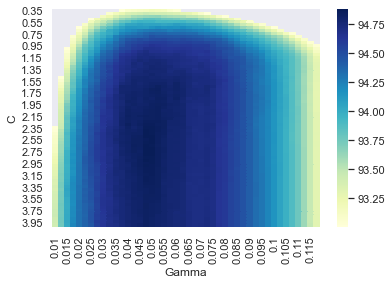

In [151]:
plt = sns.heatmap(res2,cmap="YlGnBu")
plt.figure.savefig('heatmap_pt2N.png',dpi=1200,bbox_inches='tight')

In [98]:
import matplotlib.pyplot as plt

In [96]:
KERNEL = "POLY"
POWER = 2
COEFF = 4
train_acc_list = []
test_acc_list = []
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 11.8 10.8875
0.0001 11.8 10.8875
0.001 68.8625 66.61875
0.01 91.1875 89.240625
0.1 96.25 92.25625
1.0 99.7625 92.3375
10.0 100.0 92.078125
100.0 100.0 92.078125


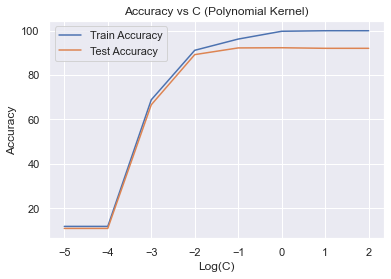

In [99]:
X = [-5,-4,-3,-2,-1,0,1,2]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (Polynomial Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (Polynomial Kernel).png',dpi=1200)
plt.show()

In [100]:
train_acc_list = []
test_acc_list = []
C = 0.3
for POWER in [0,1,2,3,4]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(POWER,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

0 11.8 10.8875
1 91.725 89.1875
2 98.4125 92.48125
3 99.9875 93.00625
4 100.0 93.4875


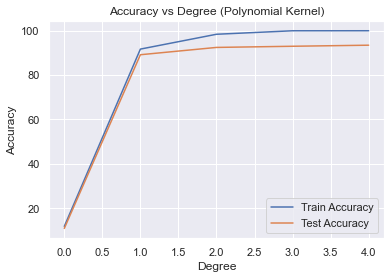

In [101]:
X = [0,1,2,3,4]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Degree')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Degree (Polynomial Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs Degree (Polynomial Kernel).png',dpi=1200)
plt.show()

In [102]:
train_acc_list = []
test_acc_list = []
C = 0.3
POWER = 3
for COEFF in [0,0.5,1,1.5,2,2.5,3,3.5,4]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(COEFF,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

0 99.1875 93.815625
0.5 99.75 94.690625
1 99.875 94.371875
1.5 99.9125 94.015625
2 99.95 93.746875
2.5 99.9625 93.565625
3 99.975 93.384375
3.5 99.9875 93.1625
4 99.9875 93.00625


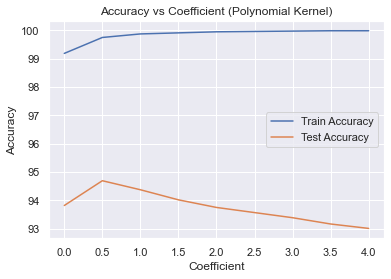

In [103]:
X = [0,0.5,1,1.5,2,2.5,3,3.5,4]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Coefficient')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Coefficient (Polynomial Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs Coefficient (Polynomial Kernel).png',dpi=1200)
plt.show()

In [116]:
def gridSearch():
    global C
    global POWER
    global COEFF
    global KERNEL
    bestC, bestP, bestCoeff = 0,0,0
    KERNEL = "POLY"
    bestAcc = 0
    for C in tqdm(np.arange(0.01,1,0.05)):
        for POWER in [1,2,3,4]:
            for COEFF in (np.arange(0,1.55,0.5)):
                try:
                    train_acc,test_acc = evaluateCrossEval(dataset_split)
                    if test_acc>bestAcc:
                        bestC = C
                        bestP = POWER
                        bestCoeff = COEFF
                        bestAcc = test_acc
                except:
                    continue
    return bestC, bestP, bestCoeff

In [117]:
bestC, bestP, bestCoeff = gridSearch()

In [118]:
bestC, bestP, bestCoeff

(0.26, 3, 0.5)

In [20]:
def getTestData():
    df = pd.read_csv('test_set.csv',header=None)
    if BINARY_CLASSIFICATION:
        df = df[(df[25] == C1) | (df[25] == C2)]
    dataset = []
    for i,row in df.iterrows():
        xi = []
        for j in range(0,NUM_FEATURES):
            xi.append(row[j])
        dataset.append(xi)
    return dataset

In [119]:
testData = getTestData()

In [120]:
np.array(testData).shape

(2000, 25)

In [23]:
KERNEL = "RBF"
C = bestC
GAMMA = bestGAMMA

In [121]:
trainDS = dataset
trainX = [train[:-1] for train in trainDS]
trainY = [train[-1] for train in trainDS]

In [25]:
prob = svm_problem(trainY,trainX)
param = svm_parameter()
kernel_string_map = {
    'LINEAR': LINEAR,
    'POLY': POLY,
    'RBF': RBF
}
param.kernel_type = kernel_string_map[KERNEL]
param.C = C
param.gamma = GAMMA
param.degree = POWER
param.coef0 = COEFF
m = svm_train(prob,param,'-q')
t_label, t_acc, t_val = svm_predict(trainY, trainX, m,'-q')
p_label, p_acc, p_val = svm_predict([], testData, m,'-q')

In [26]:
len(p_label)

2000

In [27]:
Y_pred = np.array(p_label)
with open('foo2.csv', 'w+') as f:
  f.write('Id,Class\n')
  for i in range(Y_pred.shape[0]):
    if i + 1 < 1000: 
      f.write('{},{:d}\n'.format(str(i+1), int(Y_pred[i])))
    else:
      f.write('\"{:01d},{:03d}\",{:d}\n'.format((i+1)//1000, (i+1)%1000, int(Y_pred[i])))

In [122]:
KERNEL = "POLY"
C = bestC
POWER = bestP
COEFF = bestCoeff
prob = svm_problem(trainY,trainX)
param = svm_parameter()
kernel_string_map = {
    'LINEAR': LINEAR,
    'POLY': POLY,
    'RBF': RBF
}
param.kernel_type = kernel_string_map[KERNEL]
param.C = C
param.gamma = GAMMA
param.degree = POWER
param.coef0 = COEFF
m = svm_train(prob,param,'-q')
t_label, t_acc, t_val = svm_predict(trainY, trainX, m,'-q')
p_label, p_acc, p_val = svm_predict([], testData, m,'-q')

In [123]:
Y_pred = np.array(p_label)
with open('foo3.csv', 'w+') as f:
  f.write('Id,Class\n')
  for i in range(Y_pred.shape[0]):
    if i + 1 < 1000: 
      f.write('{},{:d}\n'.format(str(i+1), int(Y_pred[i])))
    else:
      f.write('\"{:01d},{:03d}\",{:d}\n'.format((i+1)//1000, (i+1)%1000, int(Y_pred[i])))

In [127]:
np.array(dataset).shape

(8000, 26)

In [137]:
mp = {}
for e in dataset:
    label = e[25]
    if label in mp:
        mp[label] +=1
    else:
        mp[label] = 1

In [138]:
mp

{2.0: 842,
 3.0: 826,
 8.0: 761,
 1.0: 929,
 0.0: 762,
 5.0: 699,
 7.0: 815,
 9.0: 799,
 6.0: 775,
 4.0: 792}